# Adversarial Machine Learning With Tensorflow
Welcome to the demo. Adversarial machine learning has two sides to the coin: 
*Adversarial Attacks* and *Adversarial Defenses*. The attacks try to generate perturbed images which fool a classification model
without falling out of the class conditional data distribution. Defense techniques aim at making models robust to 
adversarial attacks. I assume you are familiar with these concepts. If not check out e.g 
[https://adversarial-ml-tutorial.org/introduction/](https://adversarial-ml-tutorial.org/introduction/) for a gentle introduction
with complementary code in PyTorch. This demo will study the adversarial robustness of neural network models on MNIST with Tensorflow.
For that we need adversarial attacks and models that try to defend against adversarial attacks.

### Adverarial Attacks
I implemented the adversarial attacks from scratch in the `adversarial_ml` package that can be found in the
[repository of this notebook](https://github.com/skmda37/Adversarial_Machine_Learning_Tensorflow). Below is a list
of all the attacks that are used in this notebook and a link to their original paper:

- Fast Gradient Sign Method ([Explaining And Harnessing Adversarial Examples - Goodfellow et al](https://arxiv.org/pdf/1412.6572.pdf))
- Step Least Likely ([Adversarial Machine Learning at Scale - Kurakin et al.](https://arxiv.org/pdf/1611.01236.pdf))
- Basic Iterative Method ([Adversarial Machine Learning at Scale - Kurakin et al.](https://arxiv.org/pdf/1611.01236.pdf))
- Iterative Least Likely ([Adversarial Machine Learning at Scale - Kurakin et al.](https://arxiv.org/pdf/1611.01236.pdf))
- Random Plus FGSM ([Fast Is Better Than Free: Revisiting Adversarial Training - Rice and Wong et al.](https://arxiv.org/pdf/2001.03994.pdf))
- PGD With Random Restarts ([https://arxiv.org/pdf/1706.06083.pdf](https://arxiv.org/pdf/1706.06083.pdf))

### Adversarial Defenses
We focus on the most common and arguably most effective adversarial defense: **Adversarial Training**. The idea is quite simple. 
The adversarial training algorithm simply injects adversarial examples generated by some adversarial attack into the
training batch at each iteration of the training algorithm. This way the model is trained on both clean images as well as adversarial
examples. There many hyper-parameters of adversarial training such as:

- the number of adversarial examples injected into the training batch
- the type of adversarial exmaples in the training batch, i.e. the attack used for generating adversarial examples
- the relative weight of the adversarial examples in the loss function

This notebook will not go into the details of the effects of these parameters. If you are interested, you can read
into ["Adversarial Machine Learning at Scale" - Kurakin et al.](https://arxiv.org/pdf/1611.01236.pdf) which studies adversarial training on ImageNet extensively and among other things talks about the effects
of different hyper-parameters in adversarial training on ImageNet. As a matter of fact we will

- train on training batches with half of the images being adversarial examples
- experiment with every adversarial attack listed in the section above
- weigh adversarial examples and clean images equally in the loss function for training

### What will you see in this demo

You will how different models trained on MNIST have different adversarial vulnerbailities. We will first compare fully connected
neural networks and convoltuional neural networks without adversarial training. Then we will see the drastic improvement w.r.t.
adversarial vulnerability by using adversarial training with virtually any of the adversarial attacks. Nevertheless as we will see
some types of adversarial examples for adversarial training results in much better defenses than other. Similarly we will also
see that some adversarial attacks are much harder to defend against than others. The demo will show you which attacks are the
hardest to defend against and which type of adversarial exampels for adversarial training results in the best defense.

## Imports

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from adversarial_ml import adversarial_attacks as attacks
from adversarial_ml import custom_model as models

## Load MNIST Dataset
We load the training data `(x_train,y_train)` and test data `(x_test,y_test)`. Then we perform some preprocessing. The data
is stored as `tf.Tensor` of shape `(number_images, height, width, color_channel)` and type float32. The entries of the
tensors are scaled between 0 and 1 hence we divide each entry by the maximal pixel value 255.

The shapes of the data are printed.

In [2]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess
x_train = tf.constant(x_train.reshape(60000,28, 28,1).astype("float32") / 255)
x_test = tf.constant(x_test.reshape(10000, 28, 28, 1).astype("float32") / 255)

y_train = tf.constant(y_train.astype("float32"))
y_test = tf.constant(y_test.astype("float32"))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000,)


# Build Model Architecture
We will look at two types of model architecture: **Fully connected neural networks (fc)**
and **convolutional neural networks (cnn)**.

Below we define the parameters for each of the layers in the fully connected neural networks as well as for the 
convolutional neural networks. You can play around with this yourself and change the architecture, e.g. add more layers.

In [3]:
# Parameters for the architecture of fully connected neural networks
class FcParams(object):
    def __init__(self):
        self.input_shape = [28,28,1]
        self.num_classes = 10
        self.num_fc_units = [64,32,32]

# Parameters for the architecture of convolutional neural networks
class CnnParams(object):
    def __init__(self):
        # Model hyperparameters
        self.input_shape = [28, 28, 1]
        self.num_classes = 10
        self.num_conv_filters = [32, 64, 64]
        self.kernel_size = (3, 3)
        self.pool_size = (2, 2)
        self.num_fc_units = [64]
        
fc_params = FcParams()
cnn_params = CnnParams()

Next we define two functions `get_cnn_model` and `get_fc_model` which return a convolutional neural network and 
a fully connected neural network respectively after specifiying two inputs: (1)`adv_training_with` which specifies if the model
will be trained adversarially and if so with what hyper-parameters (2) `gaussian_noise` which is the amount
of noise to put in the first layer of the model. We will use the default `gaussian_noise=0.2`. Adding noise to the training data
(not test data) when performing a forward pass is a nice little regularization. As you will see most adversarial attacks start being
effective when using a maximal perturbation size $\epsilon = 0.2$ out of $[0,1]$ which can be visually perceived as grainy noise.
Hence we will train on noisy training data. You will see that you cannot simply defend against attacks by training on noisy data
as comfortable as that would be. 

In [4]:
def get_cnn_model(adv_training_with=None, gaussian_noise=0.2):
    # Define Model layers
    inputs = tf.keras.Input(shape=cnn_params.input_shape,
                            dtype=tf.float32, name="image")

    x = inputs
    x = tf.keras.layers.GaussianNoise(stddev=gaussian_noise)(x)
    
    # Convolutional layer followed by 
    for i, num_filters in enumerate(cnn_params.num_conv_filters):
        x = tf.keras.layers.Conv2D(
            num_filters, cnn_params.kernel_size, activation='relu')(x)
        if i < len(cnn_params.num_conv_filters) - 1:
            # max pooling between convolutional layers
            x = tf.keras.layers.MaxPooling2D(cnn_params.pool_size)(x)
    
    x = tf.keras.layers.Flatten()(x)

    for num_units in cnn_params.num_fc_units:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)

    pred = tf.keras.layers.Dense(cnn_params.num_classes, activation='softmax')(x)
    

    return models.CustomModel(inputs=inputs, outputs=pred, 
                              adv_training_with=adv_training_with)

def get_fc_model(adv_training_with=None, gaussian_noise=0.2):
    # Input shape 
    inputs = tf.keras.Input(shape=fc_params.input_shape, 
                            dtype=tf.float32, name="image")

    x = inputs
    x = tf.keras.layers.GaussianNoise(stddev=gaussian_noise)(x)
    x = tf.keras.layers.Flatten()(x)

    for num_units in fc_params.num_fc_units:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)

    pred = tf.keras.layers.Dense(fc_params.num_classes, activation='softmax')(x)
    
    return models.CustomModel(inputs=inputs, outputs=pred, 
                                    adv_training_with=adv_training_with)

# Training Parameters
Here we will set some global constant parameters for training. These parameters are used for training of every model in this notebook.

In [5]:
LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = [tf.keras.metrics.SparseCategoricalAccuracy]
OPTIMIZER = tf.keras.optimizers.RMSprop()

# Fully Connected Model Without Adversarial Training
We start with a fully connected neural network that we will assign to `fc_model`. Below we print out a summary of the architecture.

In [6]:
# Build Model
fc_model = get_fc_model()
fc_model.summary()

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

Next we train the fully connected model **without adversarial training**.

In [7]:
# Compile Model
fc_model.compile(optimizer=OPTIMIZER,
              loss=LOSS, metrics=["accuracy"])

# Train Model
fc_model.fit(x_train, y_train,
             batch_size=32,
             epochs=2, validation_split=0.2)

# Evaluate Model
print("\nEvaluation on clean test data:\n")
evaluation = fc_model.evaluate(x_test, y_test, verbose=2)

Epoch 1/4
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4010 - accuracy: 0.8790 - val_loss: 0.2049 - val_accuracy: 0.9369
Epoch 2/4
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2067 - accuracy: 0.9376 - val_loss: 0.1406 - val_accuracy: 0.9575
Epoch 3/4
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1655 - accuracy: 0.9496 - val_loss: 0.1238 - val_accuracy: 0.9638
Epoch 4/4
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1429 - accuracy: 0.9569 - val_loss: 0.1257 - val_accuracy: 0.9632

Evaluation on clean test data:

313/313 - 0s - loss: 0.1163 - accuracy: 0.9643


### Adversarial Robustness For Fully Connected Neural Network
Let's visualize the results of an adversarial attack (Random Plus FGSM)) on the fullly connected model by displaying the predictions of the model for 20 clean test images and 
their corresponding adversarial examples.

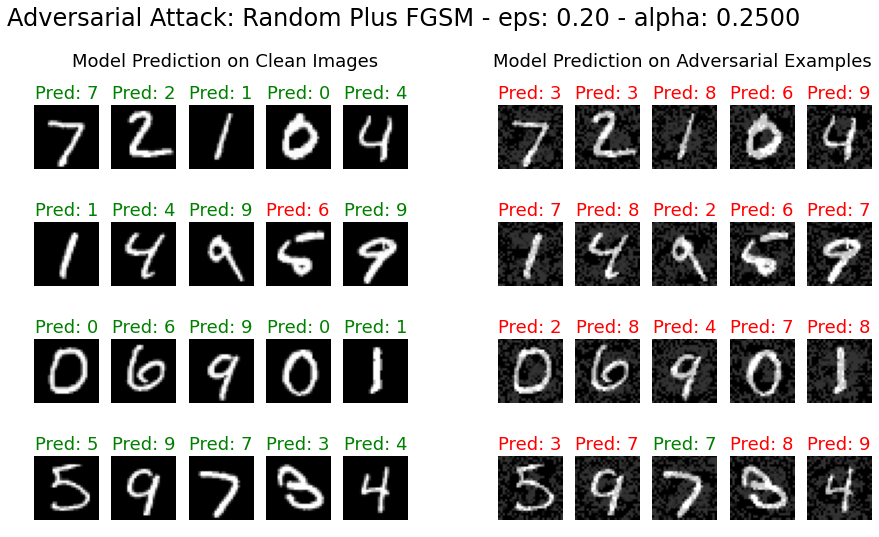

In [8]:
# Attack to be tested
Attack = attacks.RandomPlusFgsm
# Attack parameters
attack_kwargs = {"eps": 0.2, "alpha": 1.25*0.2}


attacks.attack_visual_demo(fc_model, Attack, attack_kwargs,
                           x_test[:20], y_test[:20])

Every model instance of `models.CustomModel` has a method `test_adv_robustness` which can be called on test data and prints accuracy results
on adversarial examples of different types. 

Let's test the adversarial robustness for the fully connected model by calling this method on
the test data.

In [9]:
# Test Adversarial Robustness
fc_model.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

Test adversarial robustness for model that was trained without adversarial examples
FGSM - eps: 0.20 - accuracy: 0.02
Random Plus FGSM - eps: 0.20 - alpha: 0.2000 - accuracy: 0.09
Basic Iterative Method - eps: 0.20 - alpha: 0.0050 - num_iter: 40 - accuracy: 0.0
PGD With Random Restarts - eps: 0.2 - alpha: 0.005 - num_iter: 40 - restarts: 10 - accuracy: 0.0
Iterative Least Likely (Iter 1.1) - eps: 0.20 - alpha: 0.0050 - num_iter: 40 - accuracy: 0.23
One Step Least Likely (Step 1.1) - eps: 0.20 - accuracy: 0.2


Every attack ($\epsilon=0.2$ is the default for our adversarial robustness test) manages to keep accuracy below 16%. 
The most effective attack is the *Basic Iterative Method* and the least effective attack is *One Step Least Likely*.

This is not surprising to me since the iterative method performs several (in the test 40) iterations of gradient ascent/descent and has thus more power
to minimize/maximize the adversarial objective.

In the case of *One Step Least Likely* keep in mind that the method performs only 
one step (like FGSM, Random Plus FGSM) but optimizes for a classification equal to the least likely predicted label for the clean input 
(unlike FGSM and Random Plus FGSM). 

Steering the model to the least likely predicted label (think label airplane for an image of a panda) is surely a more difficult
objective than say reducing directly the confidence of the model in the true label (FGSM, Random Plus FGSM, Basic Iterative do this).

Our take away is: Fully connected models without adversarial training are extremely vulnerable to adversarial attacks.
Let's see how vanilla convolutional neural networks compare.

# CNN Model Without Adversarial Training
Now we get a convolutional neural networks and assign it to `cnn_model`. Below we also print a summary of the architecture.

In [10]:
cnn_model = get_cnn_model()
cnn_model.summary()

Model: "custom_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)       

We train the network for as many epochs as the fully connected model (we don't change the epochs throughout the experimetns of the notebook).

In [11]:
# Compile Model
cnn_model.compile(optimizer=OPTIMIZER,
              loss=LOSS, metrics=["accuracy"])
# Train Model 
cnn_model.fit(x_train, y_train,
          batch_size=32,
          epochs=2, validation_split=0.2)

# Evaluate Model
print("\n")
evaluation = cnn_model.evaluate(x_test,y_test, verbose=2)

Epoch 1/4
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2076 - accuracy: 0.9334 - val_loss: 0.0782 - val_accuracy: 0.9778
Epoch 2/4
1500/1500 [==============================] - 19s 13ms/step - loss: 0.0633 - accuracy: 0.9805 - val_loss: 0.0474 - val_accuracy: 0.9854
Epoch 3/4
1500/1500 [==============================] - 20s 14ms/step - loss: 0.0476 - accuracy: 0.9851 - val_loss: 0.0548 - val_accuracy: 0.9843
Epoch 4/4
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0401 - accuracy: 0.9879 - val_loss: 0.0435 - val_accuracy: 0.9880


313/313 - 1s - loss: 0.0319 - accuracy: 0.9896


Next we visualize again for fun's sake how our model performs on the Random Plus FGSM attack.

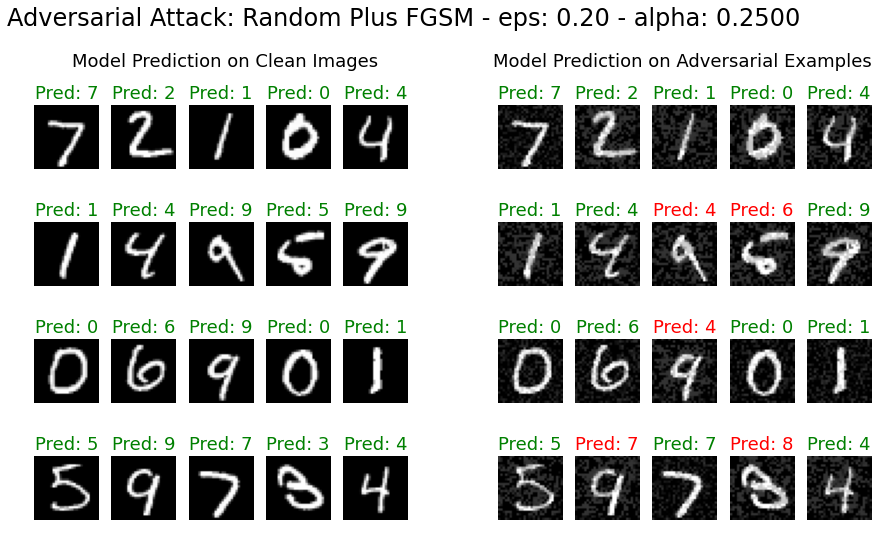

In [12]:
# Attack to be tested
Attack = attacks.RandomPlusFgsm
# Attack parameters
attack_kwargs = {"eps": 0.2, "alpha": 1.25*0.2}


attacks.attack_visual_demo(cnn_model, Attack, attack_kwargs,
                           x_test[:20], y_test[:20])

Yes these are just 20 pictures but wow! Compared to the picture for the `fc_model` we are much more robust to the adversarial attack. 

Is that just coincidence? Is this not representative? Let's find out by calling `cnn_model.test_adv_robustness` for a rigorous test on
the test data.

In [13]:
# Test Adversarial Robustness
print("\n")
cnn_model.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)



Test adversarial robustness for model that was trained without adversarial examples
FGSM - eps: 0.20 - accuracy: 0.65
Random Plus FGSM - eps: 0.20 - alpha: 0.2000 - accuracy: 0.81
Basic Iterative Method - eps: 0.20 - alpha: 0.0050 - num_iter: 40 - accuracy: 0.33
PGD With Random Restarts - eps: 0.2 - alpha: 0.005 - num_iter: 40 - restarts: 10 - accuracy: 0.32
Iterative Least Likely (Iter 1.1) - eps: 0.20 - alpha: 0.0050 - num_iter: 40 - accuracy: 0.83
One Step Least Likely (Step 1.1) - eps: 0.20 - accuracy: 0.88


**The adversarial robustness test:** This paints a clear picture. We drastically imporved our adversarial robustness by using a convolutional neural network
(`cnn_model`) instead of a fully connected neural network (`fc_model`). There is a very clear argument. Fully connected neural networks
are very prone to overfit. They are powerful models and can learn many functions and thus also many features. The problem 
that comes with that is that the model has no incnetive to learn for instance geometric shapes like we would for the classification task.

The convolutional neural network comes with an architecture that extracts features in a way that is suitable for computer vision.
Earch filter in a convilutional layer, as you surely know, slides lika a window over the previous layers and extracts features 
in a spatially invariant manner. This bias in the set of functions that can be learned helps the model learn features
that generalize well. This makes it harder for adversarial attacks to be effective against the CNN because they look for
features that are *not robust but predicitive* and can be injected with a small perturbation.

We are not too happy though. The accuracy on adversarial examples drasticallly improved but not to an acceptable level.

The basic iterative method is still classified correctly at an embarassingly low rate. Let's see if adversarial training is 
a game changer.

# Adversarial Training (With CNN Model)

Since fully conncected models are extremely vulnerable to adversarial attacks and inferior architectures for computer vision
we will continue looking at CNN (convolutional neural networks) models only. 

In this section we will look at adversarial training of CNN models only and take a look at what type of adversarial examples are 
the most effective defense.

Hence each next subsection specifies an adversarial attack that is used to generate the adversarial examples for the adversarial 
training algorithm. We start with adversarial examples generated with FGSM for adversarial trainining. 

We use a maximal perturbation size of $\epsilon=0.3$ for the adversarial examples in the adversarial training algorithm.

The number of adversarial examples in each training batch is 16 out of 32.

# Adversarial Training With FGSM
Let's take a look at adversarial training with the simple FGSM. 

In [14]:
# Set Adversarial Training Parameters
eps = 0.3
attack_kwargs = {"eps": eps}
adv_training_with = {"attack": attacks.Fgsm,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

cnn_model_fgsm = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_fgsm.compile(optimizer=OPTIMIZER,
                       loss=LOSS, metrics=["accuracy"])
cnn_model_fgsm.fit(x_train, y_train,
                   batch_size=32,epochs=2,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_fgsm.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_fgsm.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

Epoch 1/4
1500/1500 [==============================] - 26s 17ms/step - loss: 0.7285 - accuracy: 0.7535 - val_loss: 0.0858 - val_accuracy: 0.9730
Epoch 2/4
1500/1500 [==============================] - 26s 17ms/step - loss: 0.3024 - accuracy: 0.9007 - val_loss: 0.0789 - val_accuracy: 0.9756
Epoch 3/4
1500/1500 [==============================] - 25s 17ms/step - loss: 0.2306 - accuracy: 0.9240 - val_loss: 0.1064 - val_accuracy: 0.9660
Epoch 4/4
1500/1500 [==============================] - 25s 17ms/step - loss: 0.2136 - accuracy: 0.9300 - val_loss: 0.0826 - val_accuracy: 0.9762


313/313 - 1s - loss: 0.0721 - accuracy: 0.9780


Test adversarial robustness for model that was adversarially trained with FGSM - eps: 0.30 - k: 16
FGSM - eps: 0.20 - accuracy: 0.9
Random Plus FGSM - eps: 0.20 - alpha: 0.2000 - accuracy: 0.92
Basic Iterative Method - eps: 0.20 - alpha: 0.0050 - num_iter: 40 - accuracy: 0.74
PGD With Random Restarts - eps: 0.2 - alpha: 0.005 - num_iter: 40 - restarts: 10 - accuracy:

**The adversarial robustness test:** We dramatically imroved robustness against FGSM adversarial examples which is not surprising since we
trained on sucha adversarial examples. Random Plus FGSM interestingly is also defended extremely well. Basic Iterative 

# Adversarial Training With Random+FGSM

In [15]:
# Get adversarial training parameters
eps = 0.3
attack_kwargs = {"eps": eps, "alpha":1.25*eps}
adv_training_with = {"attack": attacks.RandomPlusFgsm,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}
# Build model
cnn_model_random_plus_fgsm = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_random_plus_fgsm.compile(optimizer=OPTIMIZER,
                       loss=LOSS, metrics=["accuracy"])

#Train model
cnn_model_random_plus_fgsm.fit(x_train, y_train,
                   batch_size=32,epochs=2,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_fgsm.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_random_plus_fgsm.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

Epoch 1/4
1500/1500 [==============================] - 27s 18ms/step - loss: 0.6243 - accuracy: 0.7915 - val_loss: 0.0665 - val_accuracy: 0.9803
Epoch 2/4
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2403 - accuracy: 0.9200 - val_loss: 0.0678 - val_accuracy: 0.9788
Epoch 3/4
1500/1500 [==============================] - 27s 18ms/step - loss: 0.1563 - accuracy: 0.9486 - val_loss: 0.0512 - val_accuracy: 0.9847
Epoch 4/4
1500/1500 [==============================] - 27s 18ms/step - loss: 0.1319 - accuracy: 0.9585 - val_loss: 0.0519 - val_accuracy: 0.9855


313/313 - 1s - loss: 0.0721 - accuracy: 0.9780


Test adversarial robustness for model that was adversarially trained with Random Plus FGSM - eps: 0.30 - alpha: 0.3750 - k: 16
FGSM - eps: 0.20 - accuracy: 0.93
Random Plus FGSM - eps: 0.20 - alpha: 0.2000 - accuracy: 0.97
Basic Iterative Method - eps: 0.20 - alpha: 0.0050 - num_iter: 40 - accuracy: 0.63
PGD With Random Restarts - eps: 0.2 - alpha: 0.005 - num_iter: 

**The adversarial robustness test:** We dramatically imroved robustness against FGSM adversarial examples which is not surprising since we
trained on sucha adversarial examples. Random Plus FGSM interestingly is also defended extremely well.

# Adversarial Training With Basic Iterative Method

In [16]:
# Set adversarial training parameters
eps = 0.3
num_iter = 40
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter}
adv_training_with = {"attack": attacks.BasicIter,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

# Build model
cnn_model_basic_iter = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_basic_iter.compile(optimizer=OPTIMIZER,
                       loss=LOSS, metrics=["accuracy"])

# Train model
cnn_model_basic_iter.fit(x_train, y_train,
                   batch_size=32,epochs=2,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_basic_iter.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_basic_iter.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

Epoch 1/4
1500/1500 [==============================] - 187s 125ms/step - loss: 0.7962 - accuracy: 0.7276 - val_loss: 0.1063 - val_accuracy: 0.9741
Epoch 2/4
1500/1500 [==============================] - 184s 123ms/step - loss: 0.4167 - accuracy: 0.8568 - val_loss: 0.0710 - val_accuracy: 0.9798
Epoch 3/4
1500/1500 [==============================] - 182s 121ms/step - loss: 0.3275 - accuracy: 0.8890 - val_loss: 0.0634 - val_accuracy: 0.9826
Epoch 4/4
1500/1500 [==============================] - 182s 121ms/step - loss: 0.2846 - accuracy: 0.9046 - val_loss: 0.0537 - val_accuracy: 0.9841


313/313 - 1s - loss: 0.0496 - accuracy: 0.9842


Test adversarial robustness for model that was adversarially trained with Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - k: 16
FGSM - eps: 0.20 - accuracy: 0.94
Random Plus FGSM - eps: 0.20 - alpha: 0.2000 - accuracy: 0.96
Basic Iterative Method - eps: 0.20 - alpha: 0.0050 - num_iter: 40 - accuracy: 0.94
PGD With Random Restarts - eps: 0.

**The adversarial robustness test:**

# Adversarial Training With PGD With Random Restarts

In [17]:
# Set adversarial training parameters
eps = 0.3
num_iter = 40
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter, "restarts": 10}
adv_training_with = {"attack": attacks.PgdRandomRestart,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

# Build model
cnn_model_pgd = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_pgd.compile(optimizer=OPTIMIZER,
                       loss=LOSS, metrics=["accuracy"])

# Train model
cnn_model_pgd.fit(x_train, y_train,
                   batch_size=32,epochs=2,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_pgd.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_pgd.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

Epoch 1/4
 697/1500 [============>.................] - ETA: 14:32 - loss: 1.0667 - accuracy: 0.6352

KeyboardInterrupt: 

**The adversarial robustness test:**

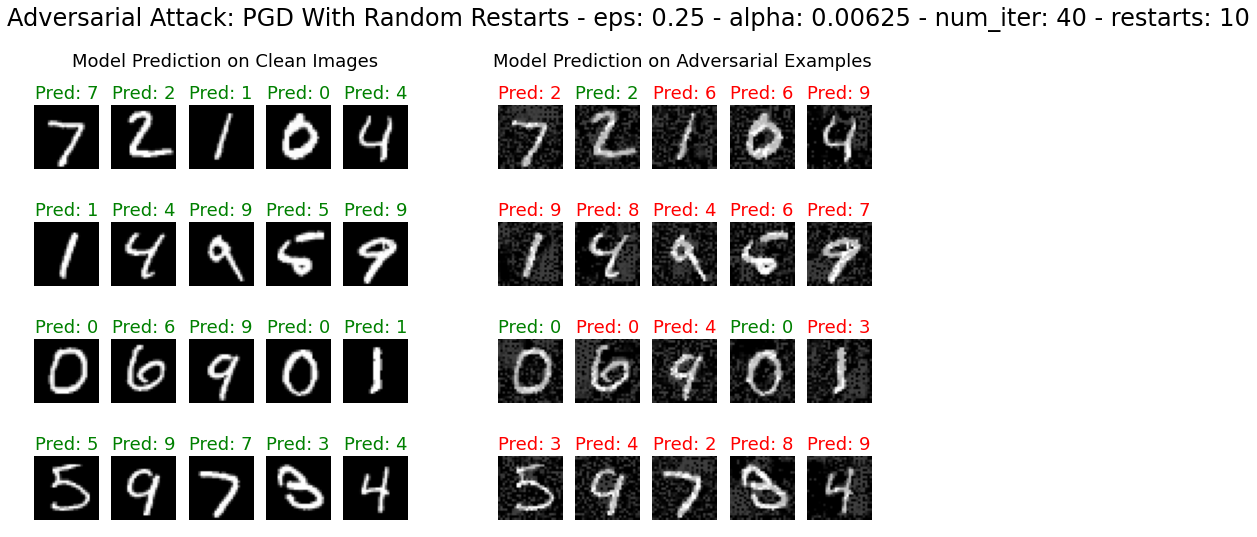

In [24]:
# Attack to be tested
Attack = attacks.PgdRandomRestart
# Attack parameters
attack_kwargs = {"eps": 0.25, "alpha": 0.25/40, "num_iter": 40, "restarts": 10}


attacks.attack_visual_demo(cnn_model_random_plus_fgsm, Attack, attack_kwargs,
                           x_test[:20], y_test[:20])

plt.savefig("images/attack_visualization")